[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanfobel/utility-bill-scraper/main?labpath=notebooks%2Fcanada%2Fon%2Fkitchener_wilmot_hydro.ipynb)

# Introduction

This notebook demonstrates scraping of data from [Kitchener-Wilmot Hydro](https://www.kwhydro.on.ca) electricity bills. You can launch an interactive version of this page by clicking on the badge at the top of the page.

## Setup

Fill in your `username` and `password` below, then run all of the cells in the notebook (press `SHIFT`+`ENTER` to run each cell individually or run the entire notebook by selecting `Run`/`Run all cells` from the menu. After the notebook finishes running (~1-5 minutes), you'll be able to download your data as a `download.zip` file (containing both a summary `monthly.csv` and the `*.pdf` statements).This file should appear in the file browser on the left and you can download it by `Right-clicking` on it and clicking `Download`.

In [1]:
username = ""
password = ""

# Plotting preferences
bin_width = 0.9
alpha = 0.5
transparent = False
bbox_inches = "tight"
facecolor = "white"

%matplotlib inline

import datetime as dt
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from matplotlib import rcParams
from cycler import cycler

import utility_bill_scraper.canada.on.kitchener_wilmot_hydro as kwh

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
def scale_rgb(colormap):
    return [(r / 255.0, g / 255.0, b / 255.0) for r, g, b in colormap]


light = scale_rgb(
    [
        (136, 189, 230),
        (251, 178, 88),
        (144, 205, 151),
        (246, 170, 201),
        (191, 165, 84),
        (188, 153, 199),
        (237, 221, 70),
        (240, 126, 110),
        (140, 140, 140),
    ]
)

rcParams.update(
    {
        "figure.figsize": (12, 6),
        "font.size": 12,
        "axes.prop_cycle": cycler("color", light),
    }
)

# Load the `.env` file into the environment if it exists
load_dotenv()

# If we haven't set a username/password, try getting them from
# environment variables.
if not username:
    username = os.getenv("KWHYDRO_USER")
if not password:
    password = os.getenv("KWHYDRO_PASSWORD")

# Set the path where data is saved.
data_path = os.getenv("DATA_PATH", os.path.join("..", "..", "..", "data"))

# Get google service account credentials (if the environment variable is set).
google_sa_credentials = os.getenv("GOOGLE_SA_CREDENTIALS")

# Uncomment the following 2 lines for development
%load_ext autoreload
%autoreload 2

api = kwh.KitchenerWilmotHydroAPI(
    username,
    password,
    data_path,
    google_sa_credentials=google_sa_credentials,
)

# Get up to 24 statements (the most recent).
updates = api.update(24)
if updates is not None:
    print(f"{ len(updates) } statements_downloaded")
api.history("monthly").tail()

Download file from google drive(file_id=16srVcNXMkblkPtm-j0nRk6D0iW5ieg48, local_path=C:\Users\Ryan\AppData\Local\Temp\tmp_zr0pfty\monthly.csv
Upload file to google drive folder(folder_id=1Tq4U1n8AjU_e1lZ8cvLVE8nHjtobH0lh, local_path=C:\Users\Ryan\AppData\Local\Temp\tmpfiazlia8\2021-11-10 - Kitchener-Wilmot Hydro - $199.14.pdf
Scrape data from C:\Users\Ryan\AppData\Local\Temp\tmpfiazlia8\2021-11-10 - Kitchener-Wilmot Hydro - $199.14.pdf
Upload file to google drive(file_id=16srVcNXMkblkPtm-j0nRk6D0iW5ieg48, local_path=C:\Users\Ryan\AppData\Local\Temp\tmp_zr0pfty\monthly.csv
1 statements_downloaded


,Total,Off Peak Consumption,Mid Peak Consumption,On Peak Consumption,Off Peak Rate,Mid Peak Rate,On Peak Rate,Total Consumption
Date,,,,,,,,
2021-07-26,104.18,459.60,149.01,115.61,0.082,0.170,0.113,724.22
2021-08-25,93.69,356.50,126.59,126.09,0.082,0.170,0.113,609.18
2021-09-23,99.80,438.80,128.16,116.26,0.082,0.170,0.113,683.22
2021-10-20,92.14,387.96,133.76,96.00,0.082,0.113,0.170,617.72
2021-11-10,199.14,436.48,170.30,127.46,0.082,0.113,0.170,734.24


## Monthly electricity consumption history

<Figure size 864x432 with 0 Axes>

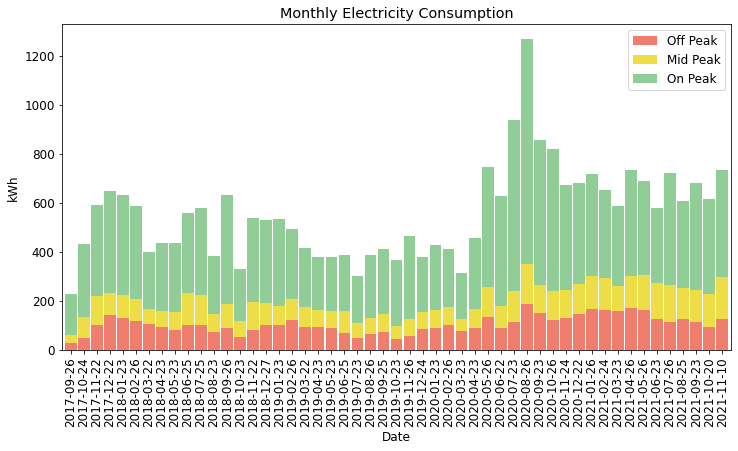

In [2]:
df = api.history("monthly")

plt.figure()
df[["On Peak Consumption", "Mid Peak Consumption", "Off Peak Consumption"]].plot.bar(
    stacked=True, width=bin_width, color=["#F07E6E", "#EDDD46", "#90CD97"]
)
plt.ylim((0, None))
plt.title("Monthly Electricity Consumption")
plt.ylabel("kWh")
plt.legend(["Off Peak", "Mid Peak", "On Peak", "Total"])
plt.savefig(
    os.path.join("images", "monthly_electricity_consumption.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Annual CO2 emissions

annual electricity usage: 8019.3 kWh
annual electricity cost: $1268.59
annual CO2 emissions from electricity: 617.49 kg


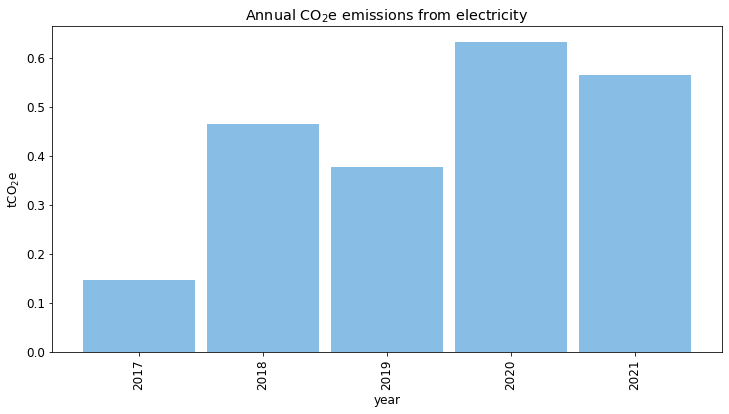

In [3]:
# Carbon intensity of electricity generation in Ontario (40-77 g CO2 / kWh)
# * 40 g / kWh (https://www.neb-one.gc.ca/nrg/sttstc/lctrct/rprt/
#               2017cndrnwblpwr/ghgmssn-eng.html)
# * 77 g / kWh (https://www.conferenceboard.ca/hcp/provincial/environment/
#               low-emitting-electricity-production.aspx)
# * This is likely to go up when Pickering is closed
#   https://www.opg.com/darlington-refurbishment/Documents/IntrinsikReport_GHG_OntarioPower.pdf

carbon_intensity_kgCO2_per_kwh = 0.077

plt.figure()
df["kgCO2"] = df["Total Consumption"] * carbon_intensity_kgCO2_per_kwh
df["year"] = [int(x[0:4]) for x in df.index]
df["month"] = [int(x[5:7]) for x in df.index]
(df.groupby("year").sum()["kgCO2"] / 1e3).plot.bar(width=bin_width)
plt.title("Annual CO$_2$e emissions from electricity")
plt.ylabel("tCO$_2$e")
plt.savefig(
    os.path.join("images", "annual_co2_emissions_electricity.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

print("annual electricity usage: %.1f kWh" % (df["Total Consumption"].iloc[-12:].sum()))
print("annual electricity cost: $%.2f" % (df["Total"].iloc[-12:].sum()))
print(
    "annual CO2 emissions from electricity: %.2f kg"
    % (df["Total Consumption"].iloc[-12:].sum() * carbon_intensity_kgCO2_per_kwh)
)

## CO2 emissions vs previous year

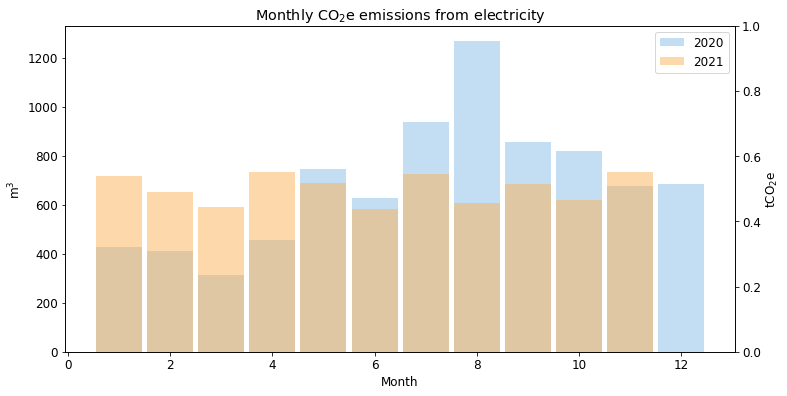

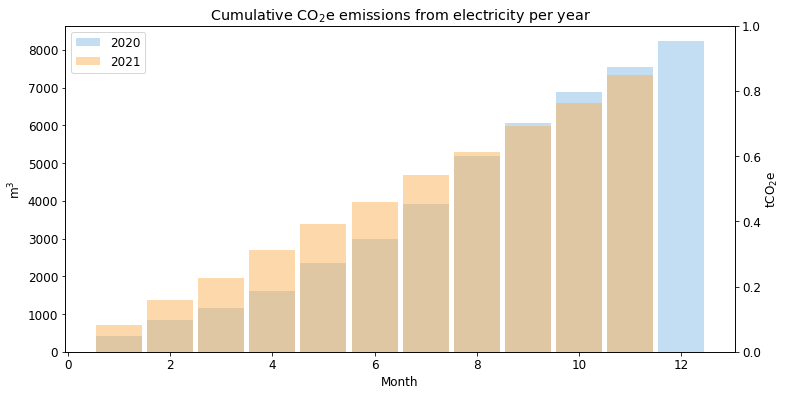

In [4]:
n_years_history = 1

plt.figure()
for year, df_year in df.groupby("year"):
    if year >= dt.datetime.utcnow().year - n_years_history:
        df_year.sort_values("month", inplace=True)
        plt.bar(
            df_year["month"],
            df_year["Total Consumption"],
            label=year,
            width=bin_width,
            alpha=alpha,
        )
plt.legend()
plt.ylabel("m$^3$")
plt.xlabel("Month")
ylim = plt.ylim()
ax = plt.gca()
ax2 = ax.twinx()
plt.ylabel("tCO$_2$e")
plt.title("Monthly CO$_2$e emissions from electricity")
plt.savefig(
    os.path.join("images", "monthly_co2_emissions_electricity.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

plt.figure()
for year, df_year in df.groupby("year"):
    if year >= dt.datetime.utcnow().year - n_years_history:
        df_year.sort_values("month", inplace=True)
        plt.bar(
            df_year["month"],
            np.cumsum(df_year["Total Consumption"]),
            label=year,
            width=bin_width,
            alpha=alpha,
        )
plt.legend()
plt.ylabel("m$^3$")
plt.xlabel("Month")
ylim = plt.ylim()
ax = plt.gca()
ax2 = ax.twinx()
plt.ylabel("tCO$_2$e")
plt.title("Cumulative CO$_2$e emissions from electricity per year")
plt.savefig(
    os.path.join("images", "cumulative_co2_emissions_electricity.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## Save data as `downloads.zip` or print link to gdrive folder

Generate a zip file with all of the data. `Right-click` on the file `downloads.zip` in the file browser on the left (it'll be in the `notebooks` folder). If `DATA_PATH` is a google drive link, print the url.

In [5]:
from utility_bill_scraper import is_gdrive_path

if is_gdrive_path(data_path):
    print(data_path)
else:
    print(shutil.make_archive(os.path.join(".", "download"), "zip", data_path))

https://drive.google.com/drive/u/0/folders/13ai3ELMsIrhjFGcv2Lqbwzb4sGkEWK-Y
